# ADULT INCOME PREDICTION

## Introduction

The income gap between people has always been significant. Some people earn millions every year. Some people are not even able to survive with their salary. 

Question: Given the variables age, final weight, education level and hours worked per week, will an individual make less than or equal to 50K, or greater than 50K a year?

We will use a dataset from the 1994 Census in the US from the UCL machine learning repository, titled “Adult Data Set” (1). 

There were originally 15 variables in the dataset (c = categorical, n = numerical): 
1. Age (n)
2. Work Class (c)
3. Final Weight (n): The number of people with the same attributes
4. Education (c)
5. Education Number (n): Highest degree achieved (1 = lowest, 16 = highest)
6. Marital Status (c)
7. Occupation (c)
8. Relationship (c)
9. Race (c)
10. Sex (c)
11. Capital Gain (n) 
12. Capital Loss (n)
13. Hours per week (n)
14. Native Country (c)
15. Income (target): <=50K, >50K

## Methods

The markdown cells below will describe the methods we used along with the code associated with it.

First, we need to load the libraries that we need.

In [27]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Then, we load data in from the web. The file that we downloaded did not have column names included, so we added those in.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

download.file(url, "data.csv")

names <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")
census <- read_csv("data.csv", col_names = names) %>%
    mutate(income = as_factor(income))

head(census)

Parsed with column specification:
cols(
  age = col_double(),
  workclass = col_character(),
  fnlwgt = col_double(),
  education = col_character(),
  education_num = col_double(),
  marital_status = col_character(),
  occupation = col_character(),
  relationship = col_character(),
  race = col_character(),
  sex = col_character(),
  capital_gain = col_double(),
  capital_loss = col_double(),
  hours_per_week = col_double(),
  native_country = col_character(),
  income = col_character()
)



age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


As shown in the 2 graphs below (“Relationship Between Capital Gain and Income Level” and “Relationship Between Capital Loss and Income Level”), these two variables are not very indicative of income level. There are many individuals in both income categories with 0 capital gain and loss. Therefore, for our analysis we will not be using these two variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



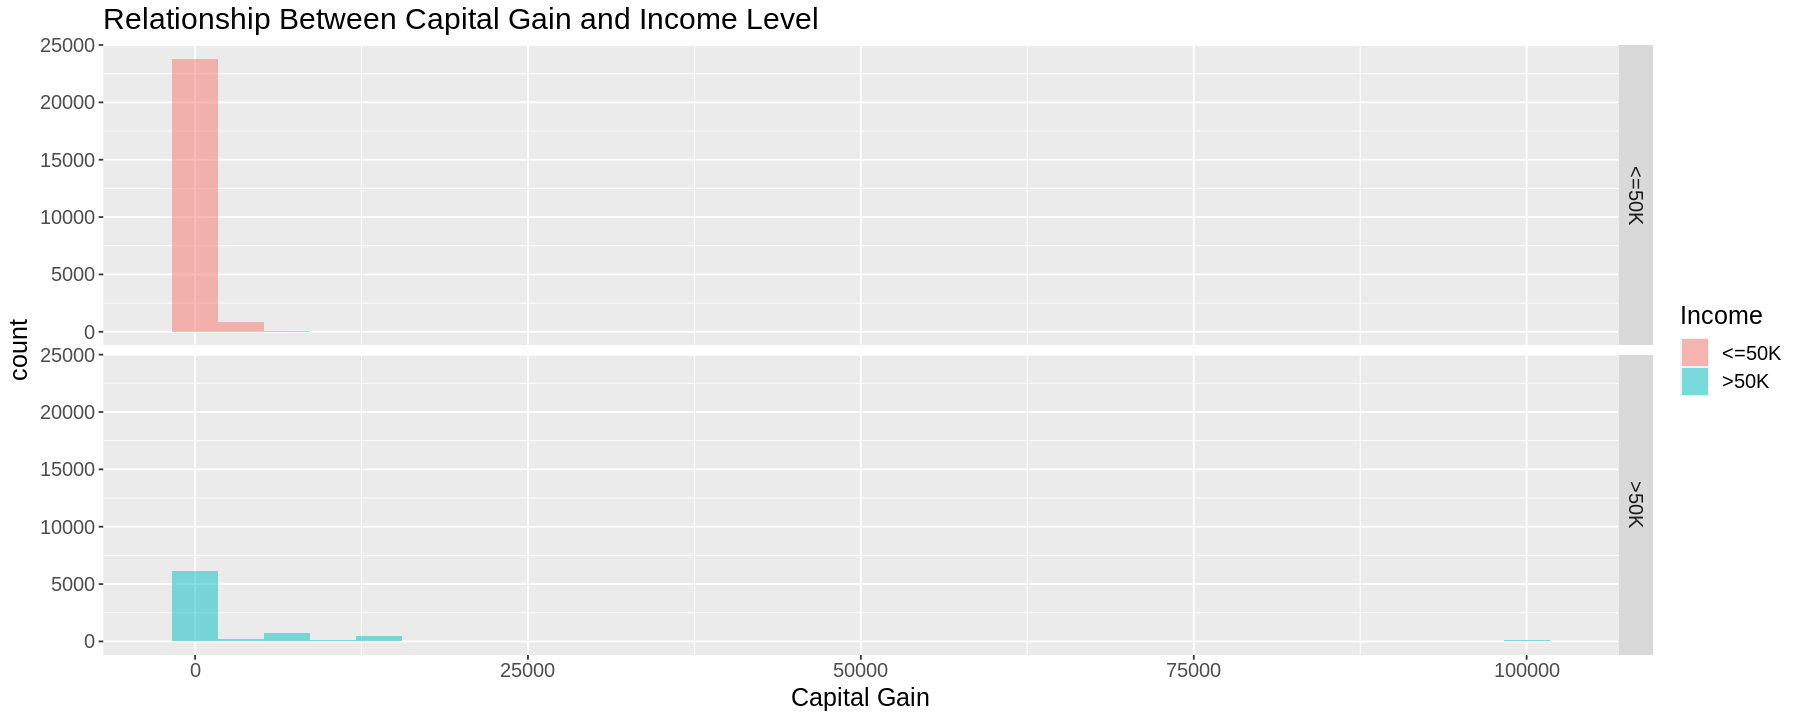

In [3]:
options(repr.plot.width = 15, repr.plot.height = 6)
gain <- census %>%
    ggplot(aes(x = capital_gain, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Gain", fill = "Income") + 
    ggtitle("Relationship Between Capital Gain and Income Level") + 
    theme(text = element_text(size = 15)) 
gain

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



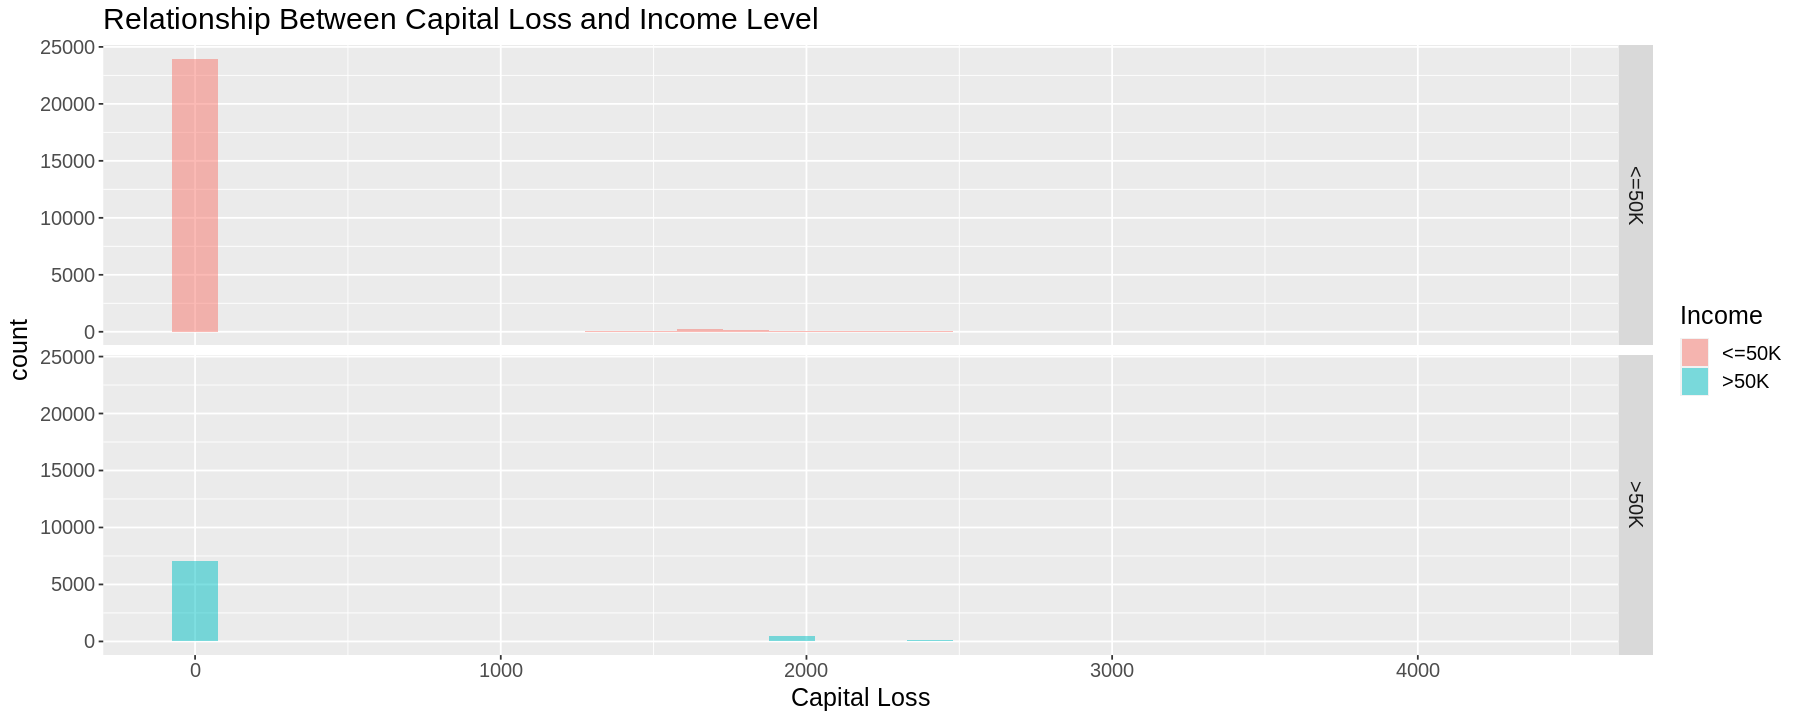

In [4]:
loss <- census %>%
    ggplot(aes(x = capital_loss, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Loss", fill = "Income") + 
    ggtitle("Relationship Between Capital Loss and Income Level") + 
    theme(text = element_text(size = 15)) 
loss

To tidy the data, we selected only the predictors we will be working with. As mentioned above, we will be removing capital_gain and capital_loss. We will also be omitting all categorical variables in our analysis since we will not be able to analyze them with K-NN classification. 

In [5]:
census_variables <- census %>%
    select(age, fnlwgt, education_num, hours_per_week, income)
head(census_variables)

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,77516,13,40,<=50K
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
28,338409,13,40,<=50K
37,284582,14,40,<=50K


To build our classifier, we split our data into train and test sets with a 75% training split. This split allows us to have a good amount of data to train our model with, while leaving sufficient data to test our model.

In [6]:
set.seed(123)

census_split <- initial_split(census_variables, prop = 0.75, strata = income)  
census_train <- training(census_split)   
census_test <- testing(census_split)

head(census_train)
# 24421 x 13
# 24421 observations in the training set with 13 categories

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,77516,13,40,<=50K
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
37,284582,14,40,<=50K
52,209642,9,45,>50K


### Preliminary Exploratory Data Analysis

We explore our training data with various tables and graphs to get a better sense of the data we are working with before we create our model.

#### Tables

##### Table 1. Number of observations in each class. 

In [7]:
num_obs <- nrow(census_train)
percentage_income <- census_train %>% 
    group_by(income) %>%
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )
percentage_income

`summarise()` ungrouping output (override with `.groups` argument)



income,count,percentage
<fct>,<int>,<dbl>
<=50K,18540,75.91827
>50K,5881,24.08173


About 76% of the individuals in the training set make less than or equal to 50k a year, while 24% make greater than 50k a year.

##### Table 2. Number of missing values.

In [8]:
missing_count <- census_train %>%
    filter(age == "?" | education_num == "?" | hours_per_week == "?" | fnlwgt == "?" | income == "?")
missing_count

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


The code above tells us whether any of our variables have missing values, which are shown as "?" in this data set. There are no missing values for the predictors that we will be using.

##### Table 3. Means of predictor variables we plan to use.

In [9]:
continuous_means <- census_train %>%
    select(age:hours_per_week) %>%
    colMeans()
continuous_means

age         fnlwgt  education_num hours_per_week 
      38.56857   189722.35224       10.07125       40.40387

The mean age in the 1994 US census is 38.6 years, average final weight is 189722, average education level is 10 and on average individuals work 40 hours per week.

#### Graphs

We used histograms to visualize the distributions of 3 of our predictor variables becuase we found that they were interesting and represented our data well. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



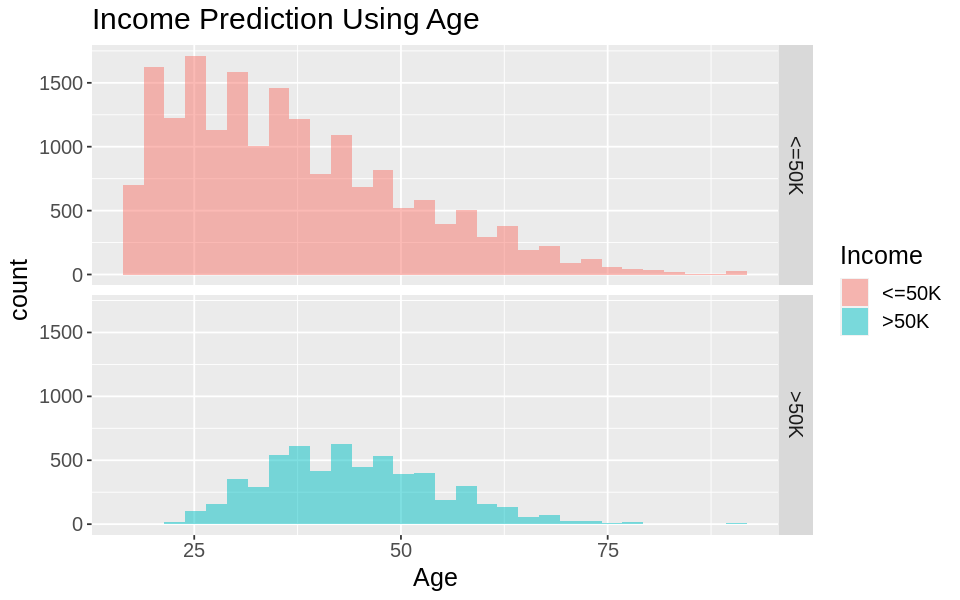

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)
age_hist <- census_train %>%
    ggplot(aes(x = age, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Age", y = "Count", fill = "Income") + 
    ggtitle("Income prediction ssing age") + 
    theme(text = element_text(size = 15)) 
age_hist

##### Figure 1. Income prediction using age.

It looks like younger individuals are more likely to make less than or equal to 50k a year. People who make more than 50k a year are most often in their 30s.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



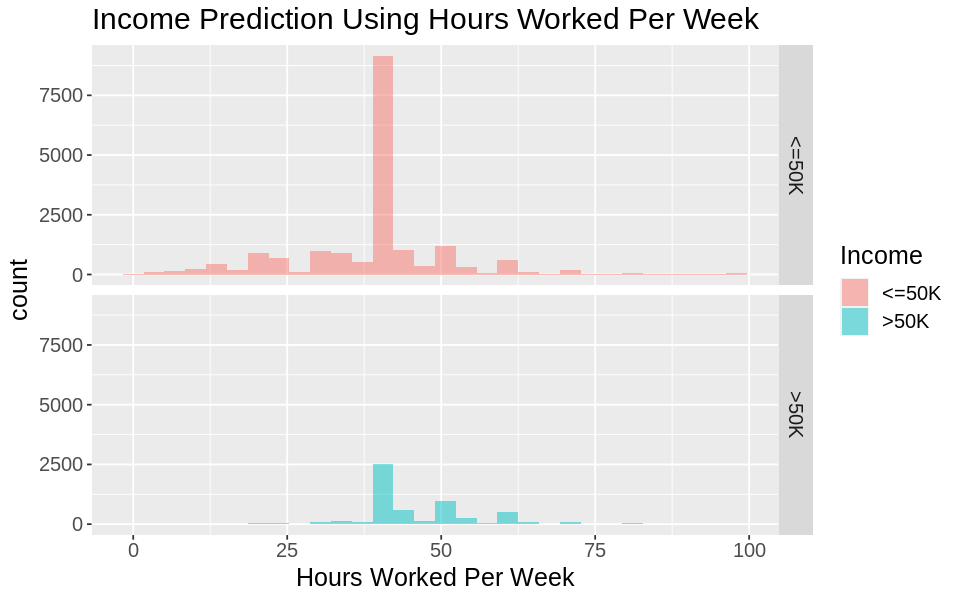

In [11]:
options(repr.plot.width = 8, repr.plot.height = 5)
hours_hist <- census_train %>%
    ggplot(aes(x = hours_per_week, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Hours Worked Per Week", y = "Count", fill = "Income") + 
    ggtitle("Income prediction using hours worked per week") + 
    theme(text = element_text(size = 15)) 
hours_hist

##### Figure 2. Income prediction using hours worked per week.

This shows that most people work 40 hours a week, pretty much regardless of the income they make. This makes sense bc 40 hours a standard work week in the US.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



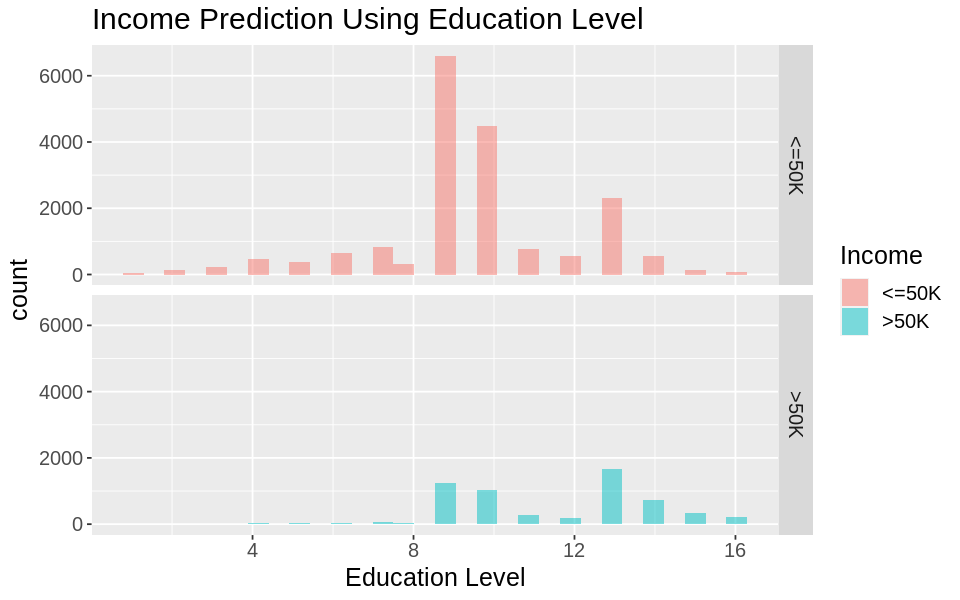

In [12]:
options(repr.plot.width = 8, repr.plot.height = 5)
education_hist <- census_train %>%
    ggplot(aes(x = education_num, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Education Level", y = "Count", fill = "Income") + 
    ggtitle("Income prediction using education level") + 
    theme(text = element_text(size = 15)) 
education_hist

##### Figure 3. Income prediction using education level

It looks like most people who make less than 50k a year have an education level of 9 or 10, but there is a wide variety of levels. On the other hand, people who make more than 50k almost exclusiveively have an education level of higher than 9. This is pretty interesting!

### Data Analysis

We are using census_train and census_test from above.

In [13]:
vfold <- vfold_cv(census_train, v = 5, strata = income)

recipe <- recipe(income ~ ., data = census_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = vfold, grid = k_vals) %>%
  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")                      



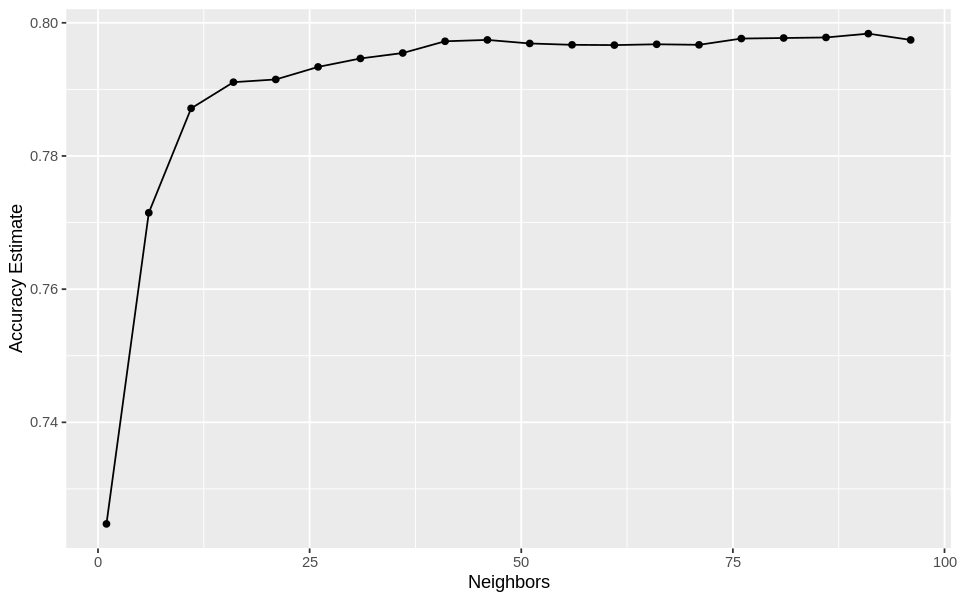

In [14]:
accuracy_vs_k

In [15]:
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(new_knn_spec) %>%
  fit(data = census_train)
                                 
predictions <- predict(knn_fit, census_test) %>%
  bind_cols(census_test)      

metrics(predictions, truth = income, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.794226


In [16]:
conf_mat(predictions, truth = income, estimate = .pred_class)

          Truth
Prediction <=50K >50K
     <=50K  5699 1194
     >50K    481  766

## Expected Outcomes and Significance

What do you expect to find?\
According to the graphs, we expect individuals who are in their 30s with higher education to have a higher income. Hours worked per week does not seem like it will have a significant impact, since most people work 40 hours a week.

What impact could such findings have?\
With this dataset, we can see what variables affect a person’s income the most and can potentially inform people of the qualities they should improve upon to increase their income. 

What future questions could this lead to?\
Since this dataset is from 1994, how will outcomes differ compared to current data (2021)? If we have a new observation from 2021, how accurate will the prediction be if we’re using a dataset from 1994? Since we were not able to analyze categorical variables, how would these affect our predictions?

### References

1. Becker, B. and Kohavi, R. (1996). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/Adult]. Irvine, CA: University of California, School of Information and Computer Science.